### Table of Contents

* [Initial Configurations](#IC)
    * [Import Libraries](#IL)
    * [Autheticate the AML Workspace](#AML)
* [Prepare for loading data in SQL tables](#GD)
    * [Setup Directory Structure](#SD)
    * [Get the SQL Database configuration](#GK)
    * [Connect to the Database](#CD)
    * [Test Database Connection](#TD)
* [Load Data in API SQL tables](#AD)
    * [Read silver zone movie reviews API  file](#RS)
    * [Create Gold API sql table](#GA)
    * [Write the transformed dataframe to the gold zone](#WS)
    * [Insert data in Gold API sql table](#ID)
    * [Test Gold API sql table](#TD)
* [Load Data in Flat File SQL tables](#FD)
    * [Read silver zone movie reviews flat  file](#RF)
    * [Create Gold file sql table](#GF)
    * [Write the transformed dataframe to the gold zone](#WF)
    * [Insert data in Gold File sql table](#ID)
    * [Test Gold File sql table](#TF)
* [Load Data in Wiki SQL tables](#WD)
    * [Read silver zone wiki file](#WF)
    * [Create Gold wiki sql table](#GW)
    * [Write the transformed dataframe to the gold zone](#WW)
    * [Insert data in Wiki sql table](#WD)
    * [Test Wikisql table](#TW)
* [Load Data in Merged SQL tables](#MD)
    * [Test JOIN query](#TJ)
    * [Create Merged Table in Synapse Database](#CT)
    * [Test merged table](#TM)
* [Write Data back from Merged SQL table in Gold Layer](#AD)
    * [Read the merged table in a dataframe](#WM)
    * [Write the merged table dataframe in gold layer](#RM)
* [Visualizations](#V)
    * [Movie rating distribution](#V1)
    * [Word Cloud from positive reviews (Data from 2 sources)](#V2)
    * [Word Cloud from negative reviews (Data from 2 sources)](#V3)
    * [20 most popular Movie Genres](#V4)
    * [Top 20 Poroduction Houses](#V5)
    * [Scatter plot of log of budget versus popularity](#V6)
    * [Word Cloud for dubbing potential (Data from 2 sources)](#V7)    

### Initial Configurations <a class="anchor" id="IC"></a>

#### Import Libraries <a class="anchor" id="IL"></a>

In [1]:
#Import required Libraries
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


import azureml.core
import azureml.automl
from azureml.core import Workspace, Dataset, Datastore

#### Autheticate the AML Workspace <a class="anchor" id="AML"></a>

In [15]:
#Autheticate the AML Workspace
workspace = Workspace.from_config()
output = {}
output['Subscription ID'] = workspace.subscription_id
output['Workspace Name'] = workspace.name
output['Resource Group'] = workspace.resource_group
output['Location'] = workspace.location
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
Subscription ID,7ca151c5-e4f7-4663-9583-834f4e0e6ed4
Workspace Name,houston-techsummit-workspace
Resource Group,calcutta_demos
Location,eastus2


### Prepare for loading data in SQL tables <a class="anchor" id="GD"></a>
- Raw data extraction for the file, API based and web datasets. Let us call this __Bronze Layer__.
- Data transformation using python from Raw to Processed stage. We will call this __Silver Layer__.
- Finally store the processed data using standard taxonomy in a SQL based serving layer. We will call this __Gold Layer__.

#### Setup Directory Structure <a class="anchor" id="SD"></a>

In [30]:
data_folder = os.path.join(os.getcwd(), 'data')
#'/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-cpu-ds12-v2/code/Users/rabiswas/Movies_Data_Consortium/data'

silver_data_folder = data_folder +"/silver"
gold_data_folder = data_folder +"/gold"

silver_api_file = silver_data_folder + "/movie_review.csv"
silver_flat_file = silver_data_folder + "/movies_metadata.csv"
silver_wiki_file = silver_data_folder + "/wiki_country_language.csv"

In [16]:
silver_wiki_file

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-cpu-ds12-v2/code/Users/rabiswas/Movies_Data_Consortium/data/silver/wiki_country_language.csv'

#### Get the SQL Database configuration <a class="anchor" id="GK"></a>

In [5]:
import credential

In [17]:
synapse_pw = credential.login['synapse_pw']
synapse_user = credential.login['synapse_user']
synapse_server = credential.login['synapse_server']

In [9]:
#There are several python SQL drivers available. However, Microsoft places its testing efforts and 
#its confidence in pyodbc driver.
#https://docs.microsoft.com/en-us/sql/connect/python/python-driver-for-sql-server?view=sql-server-ver15

In [8]:
#pip install pyodbc

#### Connect to the Database <a class="anchor" id="CD"></a>

In [82]:
import pyodbc 
#https://docs.microsoft.com/en-us/sql/connect/python/pyodbc/step-3-proof-of-concept-connecting-to-sql-using-pyodbc?view=sql-server-ver15
server = synapse_server
database = 'basepool' 
username = synapse_user
password = synapse_pw 
cnxn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()

#### Test Database Connection <a class="anchor" id="TD"></a>

In [83]:
#Sample select query
cursor.execute("SELECT @@version;") 
row = cursor.fetchone() 
while row: 
    print(row[0])
    row = cursor.fetchone()

Microsoft Azure SQL Data Warehouse - 10.0.16003.0 Apr 28 2021 04:55:16 Copyright (c) Microsoft Corporation


### Load Data in API SQL tables <a class="anchor" id="AD"></a>

#### Read silver zone movie reviews API  file <a class="anchor" id="RS"></a>

In [20]:
df_api_silver = pd.read_csv(silver_api_file)
df_api_silver.head(2)

,id,review,review_cleaned
0,862,this movie came out when i was three. now i'm twenty seven and the goddamn thing still holds up.\r\n\r\n_final rating:★★★★ - very strong appeal. a personal favourite._,movie came three im twenty seven goddamn thing still hold final rating★★★★ strong appeal personal favourite
1,8844,"throw the dice and take a turn, jumanji made the critics gurn.\r\n\r\njumanji is directed by joe johnston and based on chris van allsburg's short story of the same name. it stars robin williams, bonnie hunt, kirsten dunst, bradley pierce and jonathan hyde. the story is about a weird board game that when played unleashes hazards from the jungle with every throw of the dice. once you have started playing you have to finish the game for normality to be resumed.\r\n\r\nsimple in plot and coming off as an excuse to show off some impressive effects -said the critics - jumanji defied the critics of the time to become a box office winner and a family favourite. enough of a favourite to spawn a sequel (zathura 2005), an animated tv series and a board game. in truth the film is reliant on the effects to entertain, with the cast (all competent and enjoyable) merely lurching from one perilous throw of the dice to another. but to call the film shallow is wrong and ignorant. there's flecks of bad parenting, peer pressure, grief and bullying, while the impact of a missing child on one town is a noteworthy addition to the story line. you wonder if those critics actually paid attention during their free viewings?\r\n\r\nyes it's berserker family fun, but it's not without worth in the writing either. besides which, for the action set pieces and the laughs, they alone mean the film has its merits. 7/10",throw dice take turn jumanji made critic gurn jumanji directed joe johnston based chris van allsburg short story name star robin williams bonnie hunt kirsten dunst bradley pierce jonathan hyde story weird board game played unleashes hazard jungle every throw dice started playing finish game normality resumed simple plot coming excuse show impressive effect said critic jumanji defied critic time become box office winner family favourite enough favourite spawn sequel zathura animated tv series board game truth film reliant effect entertain cast competent enjoyable merely lurching one perilous throw dice another call film shallow wrong ignorant fleck bad parenting peer pressure grief bullying impact missing child one town noteworthy addition story line wonder critic actually paid attention free viewing yes berserker family fun without worth writing either besides action set piece laugh alone mean film merit


#### Create Gold API sql table <a class="anchor" id="GA"></a>

In [62]:
#Drop table:
drop_table_statement = """ DROP TABLE api_movie_reviews"""
cnxn.autocommit = True
cnxn.execute(drop_table_statement)

In [63]:
#Create table with the following column:
#id, review
create_table_statement = """ CREATE TABLE api_movie_reviews (
                        tmdb_id INTEGER, --"TMDB movie id"
                        review VARCHAR(8000) --"Movie review"
                        )"""
cnxn.autocommit = True
cnxn.execute(create_table_statement)

#### Write the transformed dataframe to the gold zone <a class="anchor" id="WS"></a>

In [24]:
df_api_silver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44766 entries, 0 to 44765
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              44766 non-null  int64 
 1   review          6418 non-null   object
 2   review_cleaned  6417 non-null   object
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [25]:
df_api_silver['review_cleaned'] = pd.Series(df_api_silver['review_cleaned'], dtype="string")

In [26]:
df_api_silver[['review_cleaned']] = df_api_silver[['review_cleaned']].fillna(value='')

In [27]:
df_api_silver[['review_cleaned']] = df_api_silver['review_cleaned'].str[:7999]

In [28]:
#Removed the unwanted features
df_api_silver.drop(['review'], axis=1, inplace=True)

In [72]:
gold_api_file = gold_data_folder + "/movie_review.csv"
df_api_silver.to_csv(gold_api_file, index=False)

In [73]:
df_api_gold = pd.read_csv(gold_api_file)
df_api_gold.head(2)

,id,review_cleaned
0,862,movie came three im twenty seven goddamn thing still hold final rating★★★★ strong appeal personal favourite
1,8844,throw dice take turn jumanji made critic gurn jumanji directed joe johnston based chris van allsburg short story name star robin williams bonnie hunt kirsten dunst bradley pierce jonathan hyde story weird board game played unleashes hazard jungle every throw dice started playing finish game normality resumed simple plot coming excuse show impressive effect said critic jumanji defied critic time become box office winner family favourite enough favourite spawn sequel zathura animated tv series board game truth film reliant effect entertain cast competent enjoyable merely lurching one perilous throw dice another call film shallow wrong ignorant fleck bad parenting peer pressure grief bullying impact missing child one town noteworthy addition story line wonder critic actually paid attention free viewing yes berserker family fun without worth writing either besides action set piece laugh alone mean film merit


In [34]:
gold_api_file

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-cpu-ds12-v2/code/Users/rabiswas/Movies_Data_Consortium/data/gold/movie_review.csv'

#### Insert data in Gold API sql table <a class="anchor" id="ID"></a>

In [69]:
import pyodbc 
#https://docs.microsoft.com/en-us/sql/connect/python/pyodbc/step-3-proof-of-concept-connecting-to-sql-using-pyodbc?view=sql-server-ver15
server = synapse_server
database = 'basepool' 
username = synapse_user
password = synapse_pw 
cnxn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()

In [70]:
cnxn.autocommit = True
cursor.execute("TRUNCATE TABLE dbo.api_movie_reviews")

In [78]:
#Too slow
# Insert Dataframe into SQL Server:
#cnxn.autocommit = False
#cursor = cnxn.cursor()
#cursor.execute("TRUNCATE TABLE dbo.movie_reviews_api")

#cursor.fast_executemany = True  # new in pyodbc 4.0.19
#cursor.setinputsizes([(pyodbc.SQL_INTEGER,),(pyodbc.SQL_WVARCHAR, 0)])

#insert_statement = "INSERT INTO dbo.movie_reviews_api (tmdb_id,review) values(?,?)"
#params = [(row.id, row.review_cleaned) for index, row in df_api_silver.iterrows()]
#cursor.executemany(insert_statement, df_api_gold.values.tolist())
#cursor.commit()
#cursor.close()

In [76]:
#Tooo slow
# Insert Dataframe into SQL Server:
#cursor = cnxn.cursor()
#cnxn.autocommit = True
#cursor.execute("TRUNCATE TABLE dbo.movie_reviews_api")
#cnxn.autocommit = False
# https://github.com/mkleehammer/pyodbc/wiki/Cursor#setinputsizeslist_of_value_tuples
# https://stackoverflow.com/questions/57917296/cannot-find-data-type-ntext-error-in-azure-sql-data-warehouse
# https://github.com/mkleehammer/pyodbc/issues/620
#cursor.setinputsizes([(pyodbc.SQL_INTEGER,),(pyodbc.SQL_WVARCHAR, 0)])
#for index, row in df_api_silver.iterrows():
#    cursor.execute("INSERT INTO dbo.movie_reviews_api (tmdb_id,review) values(?,?)", row.id, row.review_cleaned)
#cnxn.commit()
#cursor.close()

In [77]:
#Tooo slow
# Insert Dataframe into SQL Server:
#cnxn.autocommit = False
#cursor = cnxn.cursor()

#cursor.fast_executemany = True  # new in pyodbc 4.0.19
#cursor.setinputsizes([(pyodbc.SQL_INTEGER,),(pyodbc.SQL_WVARCHAR, 0)])

#insert_statement = "INSERT INTO dbo.api_movie_reviews (tmdb_id,review) values(?,?)"
#params = [(row.id, row.review_cleaned) for index, row in df_api_silver.iterrows()]
#cursor.executemany(insert_statement, params)
#cnxn.commit()
#cursor.close()

In [75]:
#Divide into 10 chunks and insert
cnxn.autocommit = False
chunk_size = int(df_api_gold.shape[0] / 20)
for start in range(0, df_api_gold.shape[0], chunk_size):
    df_subset = df_api_gold.iloc[start:start + chunk_size]
    print(df_subset.shape[0])
    cursor = cnxn.cursor()
    cursor.fast_executemany = True  # new in pyodbc 4.0.19
    cursor.setinputsizes([(pyodbc.SQL_INTEGER,),(pyodbc.SQL_WVARCHAR, 0)])
    insert_statement = "INSERT INTO dbo.api_movie_reviews (tmdb_id,review) values(?,?)"
    cursor.executemany(insert_statement, df_subset.values.tolist())
    cursor.commit()
    cursor.close()  

2238
2238
2238
2238
2238
2238
2238
2238
2238
2238
2238
2238
2238
2238
2238
2238
2238
2238
2238
2238
6


#### Test Gold API sql table <a class="anchor" id="TD"></a>

In [84]:
#Next lets see count of rows
cursor = cnxn.cursor()
for row in cursor.execute('select count(*) from dbo.api_movie_reviews'):
    print(row)
cursor.close()

(44766, )


In [88]:
#Next lets see example rows
cursor = cnxn.cursor()
for row in cursor.execute('SELECT TOP (2) [tmdb_id],[review] FROM [dbo].[api_movie_reviews] where review <> \'n.n\''):
    print(row)
cursor.close()

(30765, 'amazing panda adventure usually enjoy sort cheesy animal human buddy flick mediocre best kid bit annoying least shot panda panda superobvious fuzzy animatronics robot instead understandable hard make panda act imagine take away quite bit film kid probably wont notice much though got kid want get hair minute im sure putting trick still')
(9059, 'yeeeeeeaaaaaaah booooyyyyyyy fond memory demon knight day active horror community tumblr dont know good must movie good simply billy zane wearing sunglass dark commanding squad practical effect demon puppet call day sidenote know tale crypt movie would happily given cryptkeeper bookend minute actually story silly final rating??? liked would personally recommend give go')


### Load Data in Flat File SQL tables <a class="anchor" id="FD"></a>

#### Read silver zone movie reviews flat  file <a class="anchor" id="RF"></a>

In [89]:
df_flat_silver = pd.read_csv(silver_flat_file)
df_flat_silver.head(2)

,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,overview_cleaned
0,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]",862,en,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1995-10-30,373554033,81,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Toy Story,7.7,5415,led woody andy toy live happily room andy birthday brings buzz lightyear onto scene afraid losing place andy heart woody plot buzz circumstance separate buzz woody owner duo eventually learns put aside difference
1,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {'id': 10751, 'name': 'Family'}]",8844,en,"When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures.",17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'name': 'Teitler Film', 'id': 2550}, {'name': 'Interscope Communications', 'id': 10201}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1995-12-15,262797249,104,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'fr', 'name': 'Français'}]",Released,Jumanji,6.9,2413,sibling judy peter discover enchanted board game open door magical world unwittingly invite alan adult trapped inside game year living room alan hope freedom finish game prof risky three find running giant rhinoceros evil monkey terrifying creature


In [90]:
df_flat_silver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44766 entries, 0 to 44765
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                44766 non-null  int64  
 1   genres                44766 non-null  object 
 2   id                    44766 non-null  int64  
 3   original_language     44766 non-null  object 
 4   overview              44098 non-null  object 
 5   popularity            44766 non-null  float64
 6   production_companies  44766 non-null  object 
 7   production_countries  44766 non-null  object 
 8   release_date          44766 non-null  object 
 9   revenue               44766 non-null  int64  
 10  runtime               44766 non-null  int64  
 11  spoken_languages      44766 non-null  object 
 12  status                44766 non-null  object 
 13  title                 44766 non-null  object 
 14  vote_average          44766 non-null  float64
 15  vote_count         

#### Create Gold file sql table <a class="anchor" id="GF"></a>

In [92]:
#Drop table:
#drop_table_statement = """ DROP TABLE tmdb_file_movies_metadata"""
#cnxn.autocommit = True
#cnxn.execute(drop_table_statement)


#Create table tmdb_file_movies_metadata

create_table_statement = """ CREATE TABLE tmdb_file_movies_metadata (
                        budget BIGINT, --"Movie budget"
                        genres VARCHAR(8000), --"Movie genres"
                        id BIGINT, --"TMDB movie id"
                        original_language VARCHAR(8000), --"Movie original_language"
                        popularity REAL, --"Movie popularity"
                        production_companies VARCHAR(8000), --"Movie production_companies"     
                        production_countries VARCHAR(8000), --"Movie production_countries"
                        release_date VARCHAR(800), --"Movie release_date"
                        revenue BIGINT, --"Movie revenue"
                        runtime BIGINT, --"Movie runtime"
                        spoken_languages VARCHAR(8000), --"Movie spoken_languages"
                        status VARCHAR(800), --"Movie status"    
                        title VARCHAR(8000), --"Movie title"
                        vote_average REAL, --"Movie vote_average"
                        vote_count BIGINT, --"Movie vote_count"
                        overview VARCHAR(8000) --"Movie overview"                       
                        )"""
cnxn.autocommit = True
cnxn.execute(create_table_statement)

#### Write the transformed dataframe to the gold zone <a class="anchor" id="WS"></a>

In [93]:
#Removed the unwanted features
df_flat_silver.drop(['overview'], axis=1, inplace=True)

In [94]:
gold_flat_file = gold_data_folder + "/movies_metadata.csv"
df_flat_silver.to_csv(gold_flat_file, index=False)

In [95]:
df_flat_gold = pd.read_csv(gold_flat_file)
df_flat_gold.head(2)

,budget,genres,id,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,overview_cleaned
0,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]",862,en,21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1995-10-30,373554033,81,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Toy Story,7.7,5415,led woody andy toy live happily room andy birthday brings buzz lightyear onto scene afraid losing place andy heart woody plot buzz circumstance separate buzz woody owner duo eventually learns put aside difference
1,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {'id': 10751, 'name': 'Family'}]",8844,en,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'name': 'Teitler Film', 'id': 2550}, {'name': 'Interscope Communications', 'id': 10201}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1995-12-15,262797249,104,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'fr', 'name': 'Français'}]",Released,Jumanji,6.9,2413,sibling judy peter discover enchanted board game open door magical world unwittingly invite alan adult trapped inside game year living room alan hope freedom finish game prof risky three find running giant rhinoceros evil monkey terrifying creature


#### Insert data in Gold File sql table <a class="anchor" id="ID"></a>

In [96]:
#cnxn.autocommit = True
#cursor = cnxn.cursor()
#cursor.execute("TRUNCATE TABLE dbo.tmdb_file_movies_metadata")

cnxn.autocommit = False
chunk_size = int(df_flat_gold.shape[0] / 20)
for start in range(0, df_flat_gold.shape[0], chunk_size):
    df_subset = df_flat_gold.iloc[start:start + chunk_size]
    print(df_subset.shape[0])
    cursor = cnxn.cursor()
    cursor.fast_executemany = True  # new in pyodbc 4.0.19
    insert_statement = "INSERT INTO dbo.tmdb_file_movies_metadata (budget,genres,id,original_language,popularity,\
    production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,\
    title,vote_average,vote_count,overview) values(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)"
    cursor.executemany(insert_statement, df_subset.values.tolist())
    cursor.commit()
    cursor.close()

2238
2238
2238
2238
2238
2238
2238
2238
2238
2238
2238
2238
2238
2238
2238
2238
2238
2238
2238
2238
6


#### Test Gold File sql table <a class="anchor" id="TF"></a>

In [97]:
#lets see count of rows
cursor = cnxn.cursor()
for row in cursor.execute('select count(*) from dbo.tmdb_file_movies_metadata'):
    print(row)
cursor.close()

(44766, )


In [98]:
#Next lets see example rows
cursor = cnxn.cursor()
for row in cursor.execute('SELECT TOP (2) * FROM [dbo].[tmdb_file_movies_metadata]'):
    print(row)
cursor.close()

(3600000, "[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]", 451, 'en', 10.332024574279785, "[{'name': 'United Artists', 'id': 60}, {'name': 'Intial Productions', 'id': 15547}]", "[{'iso_3166_1': 'US', 'name': 'United States of America'}]", '1995-10-27', 49800000, 112, "[{'iso_639_1': 'en', 'name': 'English'}]", 'Released', 'Leaving Las Vegas', 7.099999904632568, 365, 'ben sanderson alcoholic hollywood screenwriter lost everything drinking arrives la vega drink death meet form uneasy friendship noninterference pact prostitute serum')
(44000000, "[{'id': 36, 'name': 'History'}, {'id': 18, 'name': 'Drama'}]", 10858, 'en', 5.0920000076293945, "[{'name': 'Hollywood Pictures', 'id': 915}, {'name': 'Cinergi Pictures Entertainment', 'id': 1504}]", "[{'iso_3166_1': 'US', 'name': 'United States of America'}]", '1995-12-22', 13681765, 192, "[{'iso_639_1': 'en', 'name': 'English'}]", 'Released', 'Nixon', 7.099999904632568, 72, 'allstar cast power epic look american president richa

### Load Data in Wiki SQL tables <a class="anchor" id="WD"></a>

#### Read silver zone wiki file <a class="anchor" id="WF"></a>

In [99]:
df_wiki_silver = pd.read_csv(silver_wiki_file)
df_wiki_silver.head(2)

,country,official_language,regional_language,minority_language,national_language,widely_spoken
0,Abkhaziaa,abkhaz russian,NaN,georgian,abkhaz,NaN
1,Afghanistan,pashto dari,uzbekb turkmenb pashaib nuristanib balochib pamirib,NaN,pashto,NaN


In [100]:
df_wiki_silver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   country            211 non-null    object
 1   official_language  211 non-null    object
 2   regional_language  40 non-null     object
 3   minority_language  31 non-null     object
 4   national_language  66 non-null     object
 5   widely_spoken      33 non-null     object
dtypes: object(6)
memory usage: 10.0+ KB


#### Create Gold wiki sql table <a class="anchor" id="GW"></a>

In [127]:
#Drop table:
#drop_table_statement = """ DROP TABLE wiki_country_language"""
#cnxn.autocommit = True
#cnxn.execute(drop_table_statement)


#Create table tmdb_file_movies_metadata
create_table_statement = """ CREATE TABLE wiki_country_language (
                        country VARCHAR(800), --"country"
                        official_language VARCHAR(800), --"official_language"
                        regional_language VARCHAR(8000), --"regional_language"     
                        minority_language VARCHAR(800), --"minority_language"
                        national_language VARCHAR(800), --"national_language"
                        widely_spoken VARCHAR(800), --"widely_spokens" 
                        iso_official_language VARCHAR(800) --"iso_official_language"  
                        )"""
cnxn.autocommit = True
cnxn.execute(create_table_statement)

#### Write the transformed dataframe to the gold zone <a class="anchor" id="WW"></a>

In [101]:
from iso_language_codes import *
languages = language_dictionary()

In [102]:
language_dictionary = {}

for key, values in languages.items():
    language_key = values['Name'].lower()
    language_dictionary[language_key] = key
language_dictionary['english']

'en'

In [179]:
iso_codes= []
for language in df_wiki_silver["official_language"]:
    tmp_list = language.split()
    language_temp = tmp_list[0]
    if language_temp in language_dictionary:
        iso_codes.append(language_dictionary[language_temp])
    elif len(tmp_list) >= 2:
        language_temp = tmp_list[1]
        if language_temp in language_dictionary:
            iso_codes.append(language_dictionary[language_temp])
        else:
            iso_codes.append("")
    elif language_temp=='bengali':
        iso_codes.append(language_dictionary['bangla'])            
    else:
        iso_codes.append("")
#iso_codes    
df_wiki_silver['iso_official_language'] =  iso_codes

In [180]:
df_wiki_silver.head(5)

,country,official_language,regional_language,minority_language,national_language,widely_spoken,iso_official_language
0,Abkhaziaa,abkhaz russian,NaN,georgian,abkhaz,NaN,ru
1,Afghanistan,pashto dari,uzbekb turkmenb pashaib nuristanib balochib pamirib,NaN,pashto,NaN,ps
2,Albania,albanian,NaN,greek macedonian aromanian,NaN,italian,sq
3,Algeria,arabic tamazight,NaN,NaN,arabic tamazight,french,ar
4,Andorra,catalan,NaN,spanish french portuguese,NaN,NaN,ca


In [178]:
#Removed the unwanted features
#df_wiki_silver.drop(['iso_official_language'], axis=1, inplace=True)

In [181]:
gold_wiki_file = gold_data_folder + "/wiki_country_language.csv"
df_wiki_silver.to_csv(gold_wiki_file, index=False)

In [182]:
df_wiki_gold = pd.read_csv(gold_wiki_file)
df_wiki_gold.head(5)

,country,official_language,regional_language,minority_language,national_language,widely_spoken,iso_official_language
0,Abkhaziaa,abkhaz russian,NaN,georgian,abkhaz,NaN,ru
1,Afghanistan,pashto dari,uzbekb turkmenb pashaib nuristanib balochib pamirib,NaN,pashto,NaN,ps
2,Albania,albanian,NaN,greek macedonian aromanian,NaN,italian,sq
3,Algeria,arabic tamazight,NaN,NaN,arabic tamazight,french,ar
4,Andorra,catalan,NaN,spanish french portuguese,NaN,NaN,ca


#### Insert data in Wiki sql table <a class="anchor" id="WD"></a>

In [183]:
import pyodbc 
#https://docs.microsoft.com/en-us/sql/connect/python/pyodbc/step-3-proof-of-concept-connecting-to-sql-using-pyodbc?view=sql-server-ver15
server = synapse_server
database = 'basepool' 
username = synapse_user
password = synapse_pw 
cnxn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()

In [184]:
cnxn.autocommit = True
cursor = cnxn.cursor()
cursor.execute("TRUNCATE TABLE dbo.wiki_country_language")

cnxn.autocommit = False
chunk_size = int(df_wiki_gold.shape[0] / 2)
for start in range(0, df_wiki_gold.shape[0], chunk_size):
    df_subset = df_wiki_gold.iloc[start:start + chunk_size]
    print(df_subset.shape[0])
    cursor = cnxn.cursor()
    cursor.fast_executemany = True  # new in pyodbc 4.0.19
    insert_statement = "INSERT INTO dbo.wiki_country_language (country,official_language,regional_language,minority_language,\
    national_language,widely_spoken,iso_official_language) values(?,?,?,?,?,?,?)"
    cursor.executemany(insert_statement, df_subset.values.tolist())
    cursor.commit()
    cursor.close()

105
105
1


#### Test Wikisql table <a class="anchor" id="TW"></a>

In [185]:
#Lets see count of rows
cursor = cnxn.cursor()
for row in cursor.execute('select count(*) from dbo.wiki_country_language'):
    print(row)
cursor.close()

(211, )


In [196]:
#Next lets see example rows
cursor = cnxn.cursor()
for row in cursor.execute('SELECT TOP (5) * \
                          FROM [dbo].[wiki_country_language]'):
    print(row)
cursor.close()

('Bhutan', 'dzongkha', 'n.n', 'n.n', 'n.n', 'n.n', 'dz')
('Benin', 'french', 'n.n', 'n.n', 'n.n', 'n.n', 'fr')
('Samoa', 'english', 'n.n', 'n.n', 'samoan', 'n.n', 'en')
('Lithuania', 'lithuanian', 'n.n', 'n.n', 'n.n', 'n.n', 'lt')
('Bangladesh', 'bengali', 'n.n', 'n.n', 'bengali', 'n.n', 'bn')


### Load Data in Merged SQL tables <a class="anchor" id="MD"></a>

#### Test JOIN query <a class="anchor" id="TJ"></a>

In [209]:
#Lets see count of rows
cursor = cnxn.cursor()
for row in cursor.execute('SELECT TOP (5) \
[id] \
,[genres] \
,[original_language] \
,[popularity] \
,[budget] \
,[production_companies]\
,[production_countries]\
,[release_date]\
,[revenue]\
,[runtime]\
,[spoken_languages]\
,[status]\
,[title]\
,[vote_average]\
,[vote_count]\
,[overview]\
,[Country_Additional]\
,[Language_Dubbed_Potential]\
 FROM [dbo].[tmdb_file_movies_metadata]\
  LEFT OUTER JOIN \
  (select iso_official_language, string_agg(country, \' \') Country_Additional, \
replace(string_agg(concat(official_language,\' \',regional_language) ,\' \'),\'n.n\',\'\') Language_Dubbed_Potential \
from [dbo].[wiki_country_language] \
where iso_official_language <> \'n.n\' \
group by iso_official_language) language_tab \
 ON (tmdb_file_movies_metadata.original_language = language_tab.iso_official_language) \
 INNER JOIN [dbo].[api_movie_reviews] \
 ON (tmdb_file_movies_metadata.id = api_movie_reviews.tmdb_id)'):                          
    print(row)
cursor.close()

(17, "[{'id': 27, 'name': 'Horror'}, {'id': 53, 'name': 'Thriller'}, {'id': 9648, 'name': 'Mystery'}]", 'en', 5.691507816314697, 0, "[{'name': 'Constantin Film', 'id': 47}, {'name': 'Impact Pictures', 'id': 248}, {'name': 'Isle of Man Film', 'id': 2268}, {'name': 'UK Film Council', 'id': 2452}]", "[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'iso_3166_1': 'GB', 'name': 'United Kingdom'}]", '2006-01-26', 0, 87, "[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'cy', 'name': 'Cymraeg'}]", 'Released', 'The Dark', 5.599999904632568, 76, 'adèle daughter sarah traveling welsh coastline see husband james sarah disappears different similar looking girl appears say died past time adèle try discover happened daughter tormented celtic mythology past', 'Kenya Solomon Island South Sudan Samoa Uganda Grenada Eswatini Bahamas Saint Lucia Australia Liberia New Zealand Philippine Sierra Leone Palau Zambia Malawi Seychelles Gambia Canada United State Guyana Dominica Namibia Mauritius Christmas Islan

#### Create Merged Table in Synapse Database <a class="anchor" id="CT"></a>

In [210]:
#Create table tmdb_file_movies_metadata
create_table_statement = """ CREATE TABLE [dbo].[movies_master_table] 
WITH
(
 DISTRIBUTION = ROUND_ROBIN
 ,CLUSTERED COLUMNSTORE INDEX
)
AS
SELECT
[id]
,[genres]
,[original_language]
,[popularity]
,[budget]
,[production_companies]
,[production_countries]
,[release_date]
,[revenue]
,[runtime]
,[spoken_languages]
,[status]
,[title]
,[vote_average]
,[vote_count]
,[overview]
,[Country_Additional]
,[Language_Dubbed_Potential]
,replace(review,'n.n','') review
 FROM [dbo].[tmdb_file_movies_metadata]
  LEFT OUTER JOIN 
  (select iso_official_language, string_agg(country, ' ') Country_Additional, 
replace(string_agg(concat(official_language,' ',regional_language) ,' '),'n.n','') Language_Dubbed_Potential
from [dbo].[wiki_country_language]
where iso_official_language <> 'n.n'
group by iso_official_language) language_tab
 ON (tmdb_file_movies_metadata.original_language = language_tab.iso_official_language)
 INNER JOIN [dbo].[api_movie_reviews]
 ON (tmdb_file_movies_metadata.id = api_movie_reviews.tmdb_id)
"""
cnxn.autocommit = True
cnxn.execute(create_table_statement)

#### Test merged table <a class="anchor" id="TM"></a>

In [213]:
import pyodbc 
#https://docs.microsoft.com/en-us/sql/connect/python/pyodbc/step-3-proof-of-concept-connecting-to-sql-using-pyodbc?view=sql-server-ver15
server = synapse_server
database = 'basepool' 
username = synapse_user
password = synapse_pw 
cnxn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()

In [214]:
#Count of rows
cursor = cnxn.cursor()
for row in cursor.execute('select count(*) from dbo.movies_master_table'):
    print(row)
cursor.close()

(44766, )


In [215]:
#Next lets see example rows
cursor = cnxn.cursor()
for row in cursor.execute('SELECT TOP (5) * \
                          FROM [dbo].[movies_master_table]'):
    print(row)
cursor.close()

(348346, "[{'id': 53, 'name': 'Thriller'}]", 'en', 1.6682339906692505, 0, "[{'name': 'Indy Entertainment', 'id': 41945}]", "[{'iso_3166_1': 'US', 'name': 'United States of America'}]", '2015-07-11', 0, 80, "[{'iso_639_1': 'en', 'name': 'English'}]", 'Released', 'Lethal Seduction', 5.699999809265137, 7, 'high school senior mark richards never minded overprotective widowed mothertanya good son prepares go princeton fall however come sexual spell rapacious manipulative older woman carissa barrington find middle two strong unreasonable womenone insane', 'Kenya Solomon Island South Sudan Samoa Uganda Grenada Eswatini Bahamas Saint Lucia Australia Liberia New Zealand Philippine Sierra Leone Palau Zambia Malawi Seychelles Gambia Canada United State Guyana Dominica Namibia Mauritius Christmas Island Papua New Guinea Trinidad Tobago Barbados Botswana Belize Nigeria Saint Kitts Nevis Tokelau Tuvalu Ireland Norfolk Island Coco Keeling Island Marshall Island Saint Vincent Grenadine Antigua Barbuda

### Write Data back from Merged SQL table in Gold Layer <a class="anchor" id="AD"></a>

#### Read the merged table in a dataframe <a class="anchor" id="WM"></a>

In [229]:
#Write the SQL query
read_query = pd.read_sql_query(
'''SELECT * FROM [dbo].[movies_master_table]''', cnxn)

In [230]:
#Assign the fields into the DataFrame
df_movies_master_table = pd.DataFrame(read_query, columns=['id','genres','original_language','popularity','budget','production_companies'\
                                                         ,'production_countries','release_date','revenue','runtime','spoken_languages'\
                                                         ,'status','title','vote_average','vote_count','overview','Country_Additional'\
                                                         ,'Language_Dubbed_Potential','review'])

In [231]:
df_movies_master_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44766 entries, 0 to 44765
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         44766 non-null  int64  
 1   genres                     44766 non-null  object 
 2   original_language          44766 non-null  object 
 3   popularity                 44766 non-null  float64
 4   budget                     44766 non-null  int64  
 5   production_companies       44766 non-null  object 
 6   production_countries       44766 non-null  object 
 7   release_date               44766 non-null  object 
 8   revenue                    44766 non-null  int64  
 9   runtime                    44766 non-null  int64  
 10  spoken_languages           44766 non-null  object 
 11  status                     44766 non-null  object 
 12  title                      44766 non-null  object 
 13  vote_average               44766 non-null  flo

#### Write the merged table dataframe in gold layer<a class="anchor" id="RM"></a>

In [232]:
gold_merged_data = gold_data_folder + "/movies_master_data.csv"
df_movies_master_table.to_csv(gold_merged_data, index=False)

In [234]:
df_gold_merged_data = pd.read_csv(gold_merged_data)
#It is easier to view the data if we transpose
df_gold_merged_data[df_gold_merged_data.review.notnull()].head(3).transpose()

,4,16,45
id,226458,25983,203833
genres,"[{'id': 53, 'name': 'Thriller'}, {'id': 27, 'name': 'Horror'}]","[{'id': 9648, 'name': 'Mystery'}, {'id': 27, 'name': 'Horror'}]","[{'id': 18, 'name': 'Drama'}]"
original_language,en,en,en
popularity,3.61439,5.7062,16.3736
budget,0,0,0
production_companies,"[{'name': 'GO Productions', 'id': 2943}, {'name': 'Vicarious Entertainment', 'id': 35591}, {'name': 'Bloodline Productions', 'id': 52909}, {'name': 'Shallow Focus', 'id': 52910}]","[{'name': 'Glass Eye Pix', 'id': 1360}, {'name': 'MPI Media Group', 'id': 23457}]","[{'name': 'Studio Babelsberg', 'id': 264}, {'name': 'Fox 2000 Pictures', 'id': 711}, {'name': 'Sunswept Entertainment', 'id': 5219}]"
production_countries,"[{'iso_3166_1': 'US', 'name': 'United States of America'}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'iso_3166_1': 'US', 'name': 'United States of America'}]"
release_date,2015-01-16,2009-04-25,2013-11-08
revenue,0,0,76586316
runtime,91,95,131


### Visualizations <a class="anchor" id="V"></a>

#### Movie Star Ratings distribution <a class="anchor" id="V1"></a>

In [240]:
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
df_gold_merged_data['vote_average_binned'] = pd.cut(df_gold_merged_data['vote_average'], bins=bins, labels=labels)
#df_gold_merged_data[df_gold_merged_data.review.notnull()].head(3).transpose()

In [243]:
df_gold_merged_data[['vote_average', 'vote_average_binned']].head(5)

,vote_average,vote_average_binned
0,5.7,6
1,7.7,8
2,5.6,6
3,6.0,6
4,4.7,5


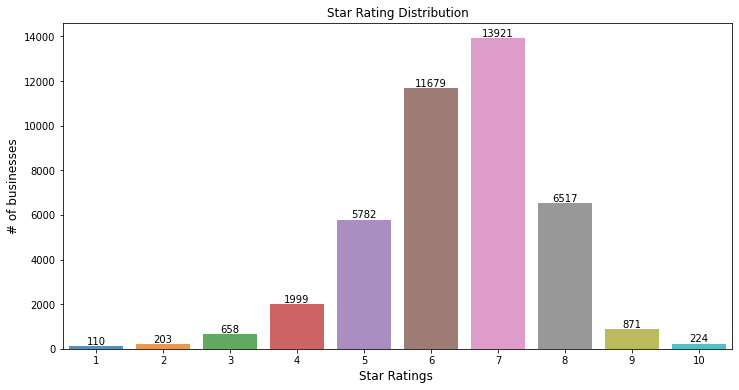

In [245]:
#Get the distribution of the ratings
x=df_gold_merged_data['vote_average_binned'].value_counts()
x=x.sort_index()
#plot
plt.figure(figsize=(12,6))
ax= sns.barplot(x=x.index, y=x.values, alpha=0.8)
plt.title("Star Rating Distribution")
plt.ylabel('# of businesses', fontsize=12)
plt.xlabel('Star Ratings ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

#### Word Cloud
As a word cloud is a graphical representation of frequently used words in the texts 
so we are going to investigate the frequency of words in the reviews.

In [248]:
from wordcloud import WordCloud

#### Word Cloud from positive reviews (Data from 2 sources) <a class="anchor" id="V2"></a>

In [246]:
# Filtering the postive reviews from the file data source
pos = df_gold_merged_data[df_gold_merged_data['vote_average_binned']>=6]['review']

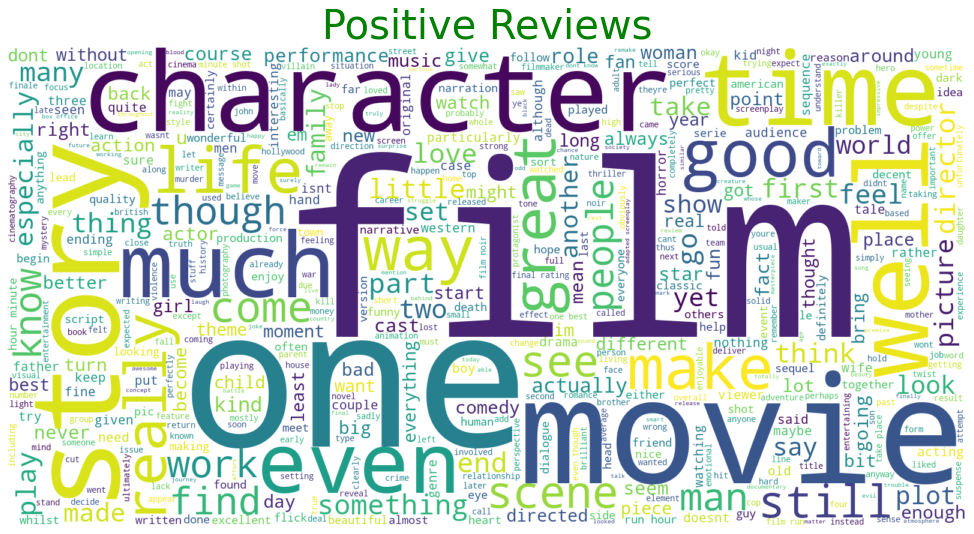

In [253]:
#### Word Cloud with Positive Reviews

wordcloud = WordCloud(width=1600, height=800, random_state=1, max_words=500, background_color='white',)
wordcloud.generate(str(set(pos)))
# declare our figure 
plt.figure(figsize=(20,10))
plt.title("Positive Reviews", fontsize=40,color='Green')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()

#### Word Cloud from negative reviews (Data from 2 sources) <a class="anchor" id="V3"></a>

In [250]:
# Filtering the neagtive reviews from the file data source
neg = df_gold_merged_data[df_gold_merged_data['vote_average_binned'] < 6]['review']

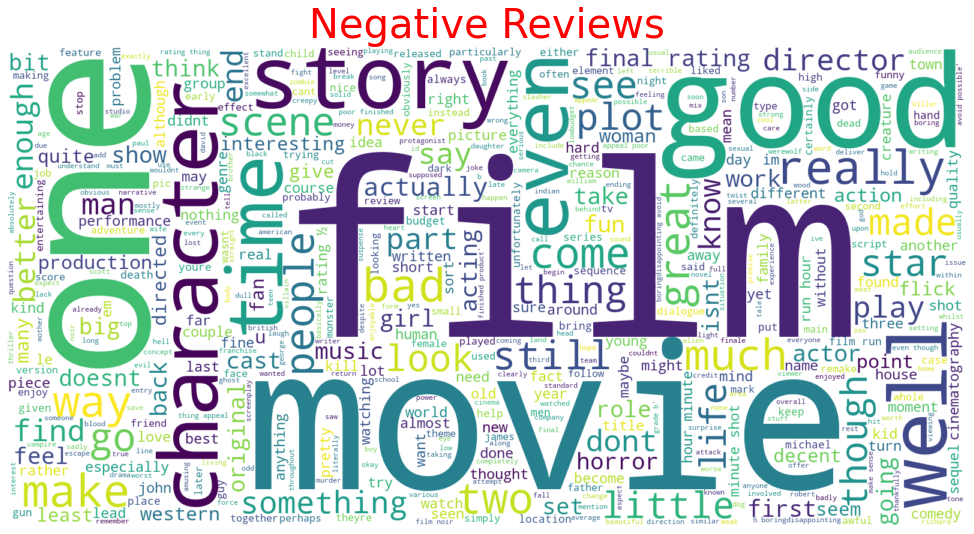

In [254]:
#### Word Cloud with Negative Reviews

wordcloud = WordCloud(width=1600, height=800, random_state=1, max_words=500, background_color='white',)
wordcloud.generate(str(set(neg)))
# declare our figure 
plt.figure(figsize=(20,10))
plt.title("Negative Reviews", fontsize=40,color='Red')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()

We can clearly see that character and story contributes heavily to both the positive and negative reviews.

#### 20 most popular Movie Genres <a class="anchor" id="V4"></a>

There are  20  different Genres in our movies data consortium!


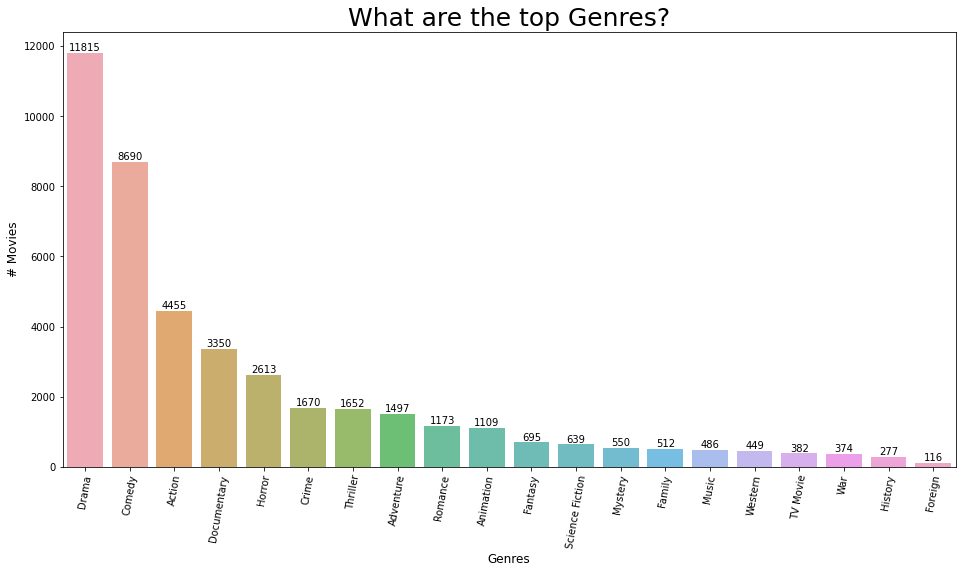

In [309]:
# Top 20 most popular movie genres
#cats=df_yelp_business.select(explode(split(col("categories"), ",\s*")).alias("category")).toPandas()
#cats['categories'] = df_yelp_business.assign(categories=df_yelp_business['categories'].str.split(',')).explode('categories')['categories']

all_words = df_gold_merged_data['genres'].str.split('\'',expand=True)
my_cat = pd.DataFrame()
my_cat['categories'] = all_words[5]
x=my_cat.categories.value_counts()

print("There are ",len(x)," different Genres in our movies data consortium!")


#prep for chart
x=x.sort_values(ascending=False)
x=x.iloc[0:20]

#chart
plt.figure(figsize=(16,8))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8)#,color=color[5])
plt.title("What are the top Genres?",fontsize=25)
locs, labels = plt.xticks()
plt.setp(labels, rotation=80)
plt.ylabel('# Movies', fontsize=12)
plt.xlabel('Genres', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

#### Top 20 Production Houses <a class="anchor" id="V5"></a>

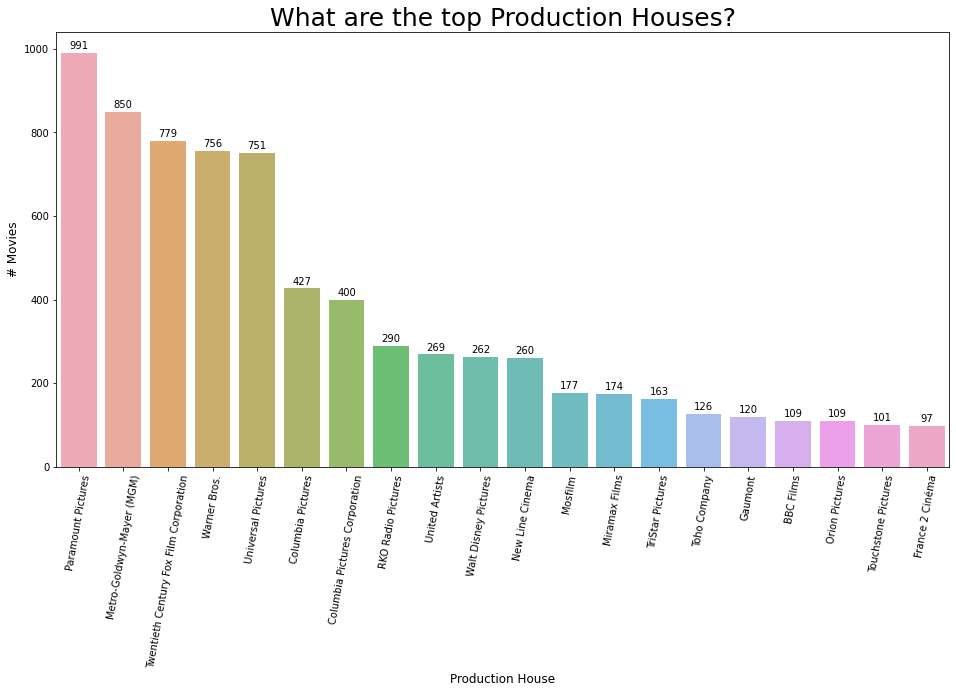

In [328]:
# Top 20 most popular Production Houses
all_words = df_gold_merged_data['production_companies'].str.split('\'',expand=True)
my_prod = pd.DataFrame()
my_prod['houses'] = all_words[3]
my_prod1 = pd.DataFrame()
my_prod1['houses'] = all_words[9]
my_prod1['houses'] = my_prod1[my_prod1.houses.notnull()]
my_prod.append(my_prod1, ignore_index=True)

x=my_prod.houses.value_counts()

#prep for chart
x=x.sort_values(ascending=False)
x=x.iloc[0:20]

#chart
plt.figure(figsize=(16,8))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8)#,color=color[5])
plt.title("What are the top Production Houses?",fontsize=25)
locs, labels = plt.xticks()
plt.setp(labels, rotation=80)
plt.ylabel('# Movies', fontsize=12)
plt.xlabel('Production House', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

#### Scatter plot of log of budget versus popularity <a class="anchor" id="V6"></a>

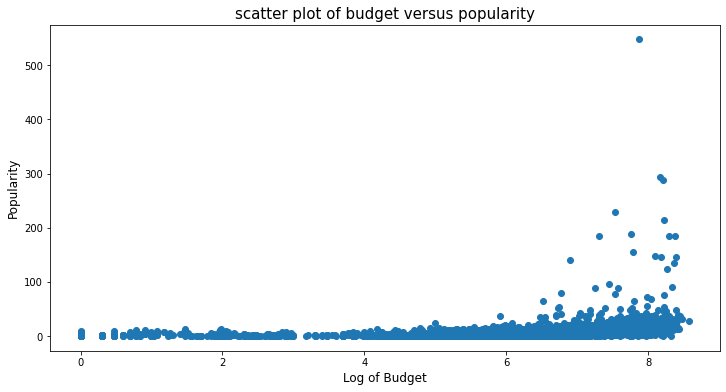

In [337]:
#Scatter plot of log of budget versus popularity. 
fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter(np.log10(df_gold_merged_data['budget']),df_gold_merged_data['popularity'])
plt.title("scatter plot of budget versus popularity",fontsize=15)
plt.xlabel("Log of Budget",fontsize=12)
plt.ylabel("Popularity",fontsize=12)
plt.show()

In [345]:
df_gold_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44766 entries, 0 to 44765
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id                         44766 non-null  int64   
 1   genres                     44766 non-null  object  
 2   original_language          44766 non-null  object  
 3   popularity                 44766 non-null  float64 
 4   budget                     44766 non-null  int64   
 5   production_companies       44766 non-null  object  
 6   production_countries       44766 non-null  object  
 7   release_date               44766 non-null  object  
 8   revenue                    44766 non-null  int64   
 9   runtime                    44766 non-null  int64   
 10  spoken_languages           44766 non-null  object  
 11  status                     44766 non-null  object  
 12  title                      44766 non-null  object  
 13  vote_average               4476

#### Word Cloud for dubbing potential (Data from 2 sources) <a class="anchor" id="V7"></a>

In [346]:
# Filtering the potential langauges for movies not produced in english 
other_than_english = df_gold_merged_data[df_gold_merged_data['original_language']!='en']['Language_Dubbed_Potential']

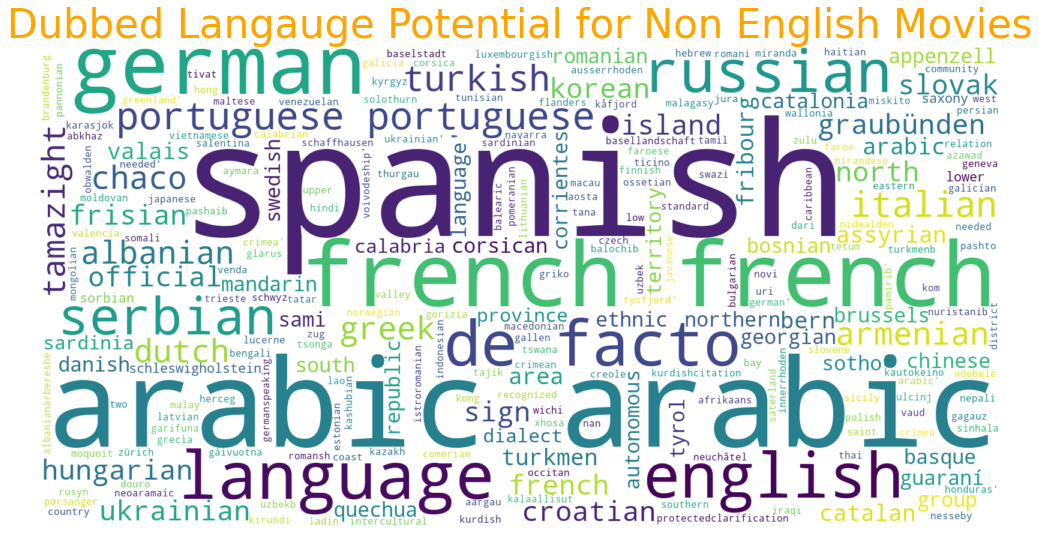

In [350]:
#### Word Cloud most potential for dubbed languages for movies not produced in english 

wordcloud = WordCloud(width=1600, height=800, random_state=1, max_words=500, background_color='white',)
wordcloud.generate(str(set(other_than_english)))
# declare our figure 
plt.figure(figsize=(20,10))
plt.title("Dubbed Langauge Potential for Non English Movies", fontsize=40,color='Orange')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()